## Data Load

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
train = pd.read_csv(r'/content/drive/My Drive/Projects/Home Credit Default Risk/train.csv')
test = pd.read_csv(r'/content/drive/My Drive/Projects/Home Credit Default Risk/test.csv')

In [19]:
train.head()

TARGET NAME_CONTRACT_TYPE  ...  credit_income_ratio  annuity_income_ratio
0     1.0         Cash loans  ...             2.007889              0.121978
1     0.0         Cash loans  ...             4.790750              0.132217
2     0.0    Revolving loans  ...             2.000000              0.100000
3     0.0         Cash loans  ...             2.316167              0.219900
4     0.0         Cash loans  ...             4.222222              0.179963

[5 rows x 78 columns]

In [0]:
categorical_columns = ['NAME_CONTRACT_TYPE', 'FLAG_OWN_REALTY','NAME_TYPE_SUITE',	'NAME_INCOME_TYPE',	'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS',
                       'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START','ORGANIZATION_TYPE','EMERGENCYSTATE_MODE',
                       'FAMILY SIZE'
                       ]

In [0]:
# label encoding snippet 
# label encoding will assign numerical values to each object value based on alphabetical order
# eg. A will be encoded as 0, B - 1, C- 2
# Helpful for High Cardinality Data - LightGBM can handle integer categorical fields

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [0]:
def label_encode(x):
  le.fit(train[x])
  train[x] = le.transform(train[x])
  test[x] = le.transform(test[x])

In [0]:
label_encode('NAME_CONTRACT_TYPE')
label_encode('FLAG_OWN_REALTY')
label_encode('NAME_TYPE_SUITE')
label_encode('NAME_INCOME_TYPE')
label_encode('NAME_EDUCATION_TYPE')
label_encode('NAME_FAMILY_STATUS')
label_encode('NAME_HOUSING_TYPE')
label_encode('OCCUPATION_TYPE')
label_encode('WEEKDAY_APPR_PROCESS_START')
label_encode('ORGANIZATION_TYPE')
label_encode('FAMILY SIZE')
label_encode('EMERGENCYSTATE_MODE')

In [9]:
train.head()

TARGET  NAME_CONTRACT_TYPE  ...  credit_income_ratio  annuity_income_ratio
0     1.0                   0  ...             2.007889              0.121978
1     0.0                   0  ...             4.790750              0.132217
2     0.0                   1  ...             2.000000              0.100000
3     0.0                   0  ...             2.316167              0.219900
4     0.0                   0  ...             4.222222              0.179963

[5 rows x 78 columns]

In [0]:
scale_pos_weight = int(train[train['TARGET']==0].shape[0]/train[train['TARGET']==1].shape[0])

In [0]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(train.iloc[:,1:], train['TARGET'], test_size = 0.2, random_state = 42)

## Light GBM

LightGBM:
*   Has faster training speed and higher efficiency
*   Consumes lower memory
*   Capable of handling large-scale data

Specifically in case of high cardinality categorical features, LightGBM is a blessing. Unlike other models, LightGBM can handle categorical data directly without the need of one-hot encoding thus needing less memory upfront. 

Handling Categorical data - LightGBM only handles integer categorical features, thus we need to convert the string data columns to integer. Scikit-learn's label encoding can be used to encode columns to int.

In genral, LGBM offers good accuracy with integer-encoded categorical features. It applies Fisher algorithm to find the optimal split over categories that performs much better than normal one-hot encoding(8X faster as per the original paper). The basic idea is to sort the categories according to the training objective at each split.

In [0]:
import lightgbm as lgb

In [0]:
# taking data as LightGBM format
lgb_train = lgb.Dataset(xtrain, label=ytrain,categorical_feature=categorical_columns)
lgb_val = lgb.Dataset(xval, label=yval,categorical_feature=categorical_columns)

In [0]:
# setup parameters for light gbm
params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : 8,
    "sub_sample":0.8,
    "num_leaves" : 31,
    "learning_rate" : 0.05,
    "seed": 42,
    "is_unbalance": 'True'
    # "scale_pos_weight": scale_pos_weight #for class imbalance
}

In [0]:
fit_lgbm = lgb.train(params, lgb_train, num_boost_round= 500, valid_sets = [lgb_train, lgb_val], verbose_eval=250, 
                early_stopping_rounds = 100)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  c_str(field_name),
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  self.feature_name = feature_name


Training until validation scores don't improve for 100 rounds.
[250]	training's auc: 0.830524	valid_1's auc: 0.774211
[500]	training's auc: 0.870861	valid_1's auc: 0.780715
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.870861	valid_1's auc: 0.780715


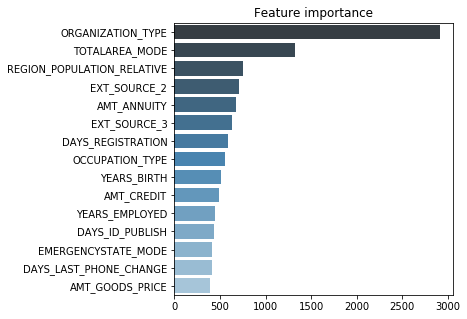

In [0]:
# Important Features

lgbm_ftr_imp = pd.Series(data=fit_lgbm.feature_importance(), index=xtrain.columns).sort_values(ascending=False)[:15]
plt.figure(figsize=(5,5))
plt.title("Feature importance")
ax = sns.barplot(y=lgbm_ftr_imp.index, x=lgbm_ftr_imp.values, palette="Blues_d", orient='h')

In [0]:
# load submission file
submission = pd.read_csv(r'/content/drive/My Drive/Projects/Home Credit Default Risk/sample_submission.csv')

In [0]:
submission['TARGET'] = fit_lgbm.predict(test, num_iteration=fit_lgbm.best_iteration)

In [0]:
submission.head()

SK_ID_CURR    TARGET
0      100001  0.470287
1      100005  0.637619
2      100013  0.119221
3      100028  0.361829
4      100038  0.690823

In [0]:
submission.to_csv('lgbm_pred.csv',index = False)

Test AUC of 72.5%

In [0]:
# lgb.cv(params, lgb.Dataset(xtrain, label=ytrain,categorical_feature=categorical_columns), 500, nfold=2)

In [0]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {"num_leaves": [4,6,8], # main parameter to control the complexity of the tree model
#               "max_depth": [8,4,6], # to deal with over-fitting 
#               "max_bin": [4,8,10], #large for better accuracy; max number of bins that feature values will be bucketed in
#               "learning_rate" : [0.01,0.05,0.1]
#              }

# lg = lgb.LGBMClassifier()

# grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_grid, cv = 3, scoring= 'roc_auc', verbose=5)
# grid_search.fit(xtrain,ytrain)
# grid_search.best_estimator_

## CatBoost

CatBoost handles categorical data the best without any preprocessing requirement. Instead of one-hot encoding, categorical features in CatBoost are used to build new numeric features leveraging various statistics on different combinations of features (refer to the orginal paper to understand this in depth).

Note - Never one-hot encode categorical features by yourself.

CatBoost is a tuned algorithm, though usually slower than XGBoost and LightGBM but it performs the best wthout much effort needed on tuning. Also, CatBoost in general is relatively more resistant to overfitting.

In [0]:
train = pd.read_csv(r'/content/drive/My Drive/Projects/Home Credit Default Risk/train.csv')
test = pd.read_csv(r'/content/drive/My Drive/Projects/Home Credit Default Risk/test.csv')

In [0]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(train.iloc[:,1:], train['TARGET'], test_size = 0.2, random_state = 42)

In [17]:
!pip install catboost

import catboost
from catboost import Pool, CatBoostClassifier,cv

     |████████████████████████████████| 63.9MB 45kB/s 


In [0]:
# # catboost categorical features should be int or str

# for col in categorical_columns:
#   if xtrain[col].dtypes == 'float64':
#     xtrain = xtrain[col].astype(int)
#     xval = xval[col].astype(int)
#     test = test[col].astype(int)

In [0]:
cat_train = Pool(xtrain, label=ytrain,cat_features= categorical_columns)
cat_valid = Pool(xval, label=yval,cat_features= categorical_columns)

In [75]:
model = CatBoostClassifier(subsample=0.6,
                           custom_loss='Logloss',
                           l2_leaf_reg = 10,
                           random_strength = 0,
                           max_depth=7,
                           eval_metric="AUC",
                           learning_rate=0.03,
                           iterations=60000,
                           bootstrap_type='Bernoulli',
                           task_type="GPU",
                           random_seed=42,
                           od_type="Iter")

fit_model = model.fit(cat_train,verbose_eval=1000, early_stopping_rounds=100,eval_set=[cat_valid],use_best_model=True,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7126342	test: 0.7146529	best: 0.7146529 (0)	total: 93.7ms	remaining: 1h 33m 39s
1000:	learn: 0.8151935	test: 0.7864572	best: 0.7864572 (1000)	total: 58.7s	remaining: 57m 37s
2000:	learn: 0.8520523	test: 0.8026654	best: 0.8026654 (2000)	total: 1m 58s	remaining: 57m 19s
3000:	learn: 0.8790419	test: 0.8130631	best: 0.8130631 (3000)	total: 3m 1s	remaining: 57m 25s
4000:	learn: 0.9005332	test: 0.8211649	best: 0.8211681 (3998)	total: 4m 5s	remaining: 57m 12s
5000:	learn: 0.9178153	test: 0.8272212	best: 0.8272212 (5000)	total: 5m 12s	remaining: 57m 18s
6000:	learn: 0.9322537	test: 0.8323096	best: 0.8323096 (6000)	total: 6m 20s	remaining: 56m 59s
7000:	learn: 0.9448227	test: 0.8373133	best: 0.8373133 (7000)	total: 7m 30s	remaining: 56m 49s
8000:	learn: 0.9548655	test: 0.8405288	best: 0.8405288 (8000)	total: 8m 43s	remaining: 56m 44s
9000:	learn: 0.9634320	test: 0.8435320	best: 0.8435320 (9000)	total: 10m	remaining: 56m 42s
10000:	learn: 0.9706032	test: 0.8457288	best: 0.8457357 (99

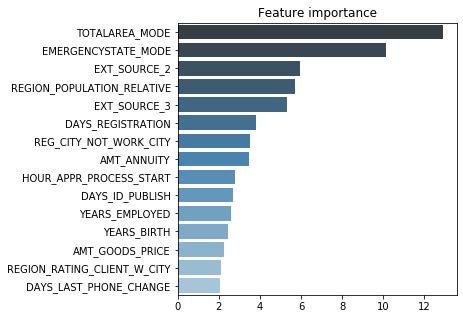

In [77]:
# Important Features

cat_ft_imp = pd.Series(data=fit_model.get_feature_importance(), index=xtrain.columns).sort_values(ascending=False)[:15]
plt.figure(figsize=(5,5))
plt.title("Feature importance")
ax = sns.barplot(y=cat_ft_imp.index, x=cat_ft_imp.values, palette="Blues_d", orient='h')

In [0]:
submission['TARGET'] = pd.DataFrame(fit_model.predict_proba(test))[1]
submission.to_csv('catboost_pred.csv',index = False)

Test Score - 0.714